In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
directory = "/Users/abittaraev/Desktop/AB_Test_Results.xlsx"
df = pd.read_excel(directory, header=0)

In [4]:
df.sort_values("USER_ID", inplace = True)
df.reset_index(inplace=True, drop=True)
df.info() #check for missing data
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
USER_ID         10000 non-null int64
VARIANT_NAME    10000 non-null object
REVENUE         10000 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,3,variant,0.0
4,3,variant,0.0
5,3,control,0.0
6,4,variant,0.0
7,5,variant,0.0
8,6,variant,0.0
9,9,variant,0.0


We are not dealing with crossover plans, where same units get different treatments over a period of time. So, for purposes of this example we discard units with treatment/control intersections. We are not addressing how to deal with these intersections, we assume random sampling and disjoint split.

In [5]:
# count treatments for user_id
df_gr=df.groupby('USER_ID')['VARIANT_NAME'].nunique().reset_index()
df_gr.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [6]:
# find re-used user_ids and remove them
df_to_del = df_gr.loc[df_gr.VARIANT_NAME > 1, ['USER_ID']]
df_mg = pd.merge(df, df_to_del, how='left', on='USER_ID', indicator=True)
df_corr = df_mg.loc[df_mg._merge == 'left_only', ['USER_ID', 'VARIANT_NAME', 'REVENUE']]
df_corr.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
6,4,variant,0.0
7,5,variant,0.0
8,6,variant,0.0
9,9,variant,0.0
12,11,control,0.0
13,11,control,0.0
14,12,control,0.0


In [7]:
#summary stats
df_corr.groupby("VARIANT_NAME")["REVENUE"].describe()

VARIANT_NAME       
control       count    3026.000000
              mean        0.155506
              std         3.708620
              min         0.000000
              25%         0.000000
              50%         0.000000
              75%         0.000000
              max       196.010000
variant       count    3044.000000
              mean        0.058909
              std         0.760344
              min         0.000000
              25%         0.000000
              50%         0.000000
              75%         0.000000
              max        23.040000
Name: REVENUE, dtype: float64

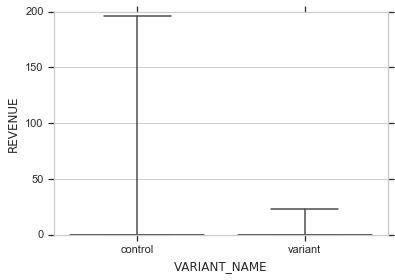

In [26]:
#box-plot
sns.set(style="whitegrid")
sns.boxplot(x='VARIANT_NAME',y='REVENUE',data=df_corr)

Distributions of REVENUE for both groups are assymetric. The fact that $\gt 75\%$ of observations are zeros (see boxplots) tells us that one of the suitable models for this data could be ZIPR (zero inflated poisson). For now we restrict ourselves with a simple Poisson distribution. Supposer that the data-generation follows $ X_{test} \sim Poisson(\lambda_1) $  and  $ X_{control} \sim Poisson(\lambda_2)$ 

In [29]:
#recode REVENUE as binary variable (convert / non-convert) 
#to represent Poisson counts per unit of exposure
df_corr['convert'] = df_corr.REVENUE.apply(lambda x: 1 if x > 0.00  else 0)
df_corr.groupby("VARIANT_NAME")["convert"].describe()

VARIANT_NAME       
control       count    3026.000000
              mean        0.017845
              std         0.132411
              min         0.000000
              25%         0.000000
              50%         0.000000
              75%         0.000000
              max         1.000000
variant       count    3044.000000
              mean        0.014126
              std         0.118030
              min         0.000000
              25%         0.000000
              50%         0.000000
              75%         0.000000
              max         1.000000
Name: convert, dtype: float64

To illustrate why coonvertion events are rare, we need to estimate both lambdas as 
$\hat{\lambda} = \frac{\sum{successes}}{total \ exposure}$  

In [32]:
dff=df_corr.groupby("VARIANT_NAME")["USER_ID"].count().reset_index()
n = dff.loc[dff["VARIANT_NAME"]=='variant']["USER_ID"].values[0]
m = dff.loc[dff["VARIANT_NAME"]=='control']["USER_ID"].values[0]
dff_s=df_corr.groupby("VARIANT_NAME")["convert"].sum().reset_index()
s1= dff_s.loc[dff["VARIANT_NAME"]=='variant']["convert"].values[0]
s2= dff_s.loc[dff["VARIANT_NAME"]=='control']["convert"].values[0]
print("Sample size test (n): % 2d" %(n) )  
print("Sample size control (m): % 2d" %(m) )  
print("Successes test: % 2d" %(s1))  
print("Successes control: % 2d" %(s2))  

Sample size test (n):  3044
Sample size control (m):  3026
Successes test:  43
Successes control:  54


Because we sample our $iid$ variables from $Poisson(\lambda)$ _n_ and _m_ times we can use these  sample sizes as exposures for both groups. Therefore, $\hat{\lambda_1} = \frac{43}{3044} = 0.014$ and $\hat{\lambda_2} = \frac{54}{3026} = 0.018$.

From these rate estimates we can see that  we expect (on average) per each unit of exposure (i.e. per each user) about $1\%$ of conversions. _Pro rata temporis_ we expect (on average) 43 conversions per 3044 units of exposure and 53 per 3026 in test and control groups respctively. 

This summation of successes is due to the fact that: 
* $X_{1},X_{2},...,X_{n_1}$ are _iid_ $Poisson(\lambda)$, then $X = \sum_{i=1}^{n} X_{i} \sim Poisson(n\lambda)$

This fact can be used to from a hypotheses.
* First, rewrite  the parameters as $\lambda_1,\lambda_2$ как $ r_1 = n\lambda_1, r_2 = m\lambda_2$ 
* Then define $\theta = \frac{\lambda_1}{\lambda_2}$
* Then, it is well known that if $ X_{test} \sim {Poisson(r_1)} $ and  $ X_{control} \sim {Poisson(r_2)} $ are independent, then
$ X_{test}  \lvert  X_{test} + X_{control} =  k \sim {Binomial(k,p(\theta))} $, где k=number of trials and 
$p(\theta) = \frac{r_1}{r_1 + r_2}$.
* $\lambda_1= \theta\lambda_2 $, it follows that $\frac{r_1}{r_1 + r_2}$ 
    = $\frac{n\theta\lambda_2}{n\theta\lambda_2 + m\lambda_2} = \frac{n\theta}{n\theta + m}$
* Now, under $H_0: \theta=\frac{\lambda_1}{\lambda_2} \leq 1 <=> p(\theta)\leq \frac{n}{n+m}$ and 
$H_a: \theta=\frac{\lambda_1}{\lambda_2} \gt 1 <=> p(\theta)\gt \frac{n}{n+m}$

In [35]:
pi=n/(n+m)
print("Proportion of succeses under H_0 : % 5f" %(pi) )  

Proportion of succeses under H_0 :  0.501483


Let's see how likely it is to observe a binomial proportion larger than 0.501483 

In [36]:
p_val=scipy.stats.binom_test(s1,s1+s2,pi,alternative="greater")
print("P_value of the test : % 5f" %(p_val))  

P_value of the test :  0.894013
Cannot reject H_0


With this data we can not reject the $H_0$ which can be translated as "the ratio of two Poisson rates is not statistically different from 1". So, the conversion rates are basically the same and our experiment hasn't shown any effectiveness of the test variant over the control variant. 